# Mini Project: Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
env??

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [4]:
#the dealer's one showing card  - 1 to 10, where 1 is ace

for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        #done if action is zero
        print (action)
        state, reward, done, info = env.step(action)
        print (state, reward, done)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(14, 9, False)
0
(14, 9, False) -1.0 True
End game! Reward:  -1.0
You lost :(

(13, 1, False)
1
(14, 1, False) 0 False
(14, 1, False)
1
(24, 1, False) -1 True
End game! Reward:  -1
You lost :(

(14, 5, True)
0
(14, 5, True) -1.0 True
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
def generate_episode_from_limit(bj_env): #limit of 18
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [6]:
for i in range(3):
    print(generate_episode_from_limit(env)) 
    
# [((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)] - in this episode, we got 10, not usable ace
# we took random action - got 1, got to 20 from another card, decided to stick
# house drew cards till it reached 17 - eventually got busted and we won - as we cannot control
# this step, only the first facing card of house is important
    

[((12, 5, False), 1, -1)]
[((8, 10, False), 1, 0), ((16, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[((16, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [7]:
from collections import defaultdict
import numpy as np
import sys
#generate_episode - gives function connecting an environment
#needs to be called inside a loop to get values
def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    countelements=defaultdict(list)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # each episode can have multiple hits
        # but reward is only the last value
        # but it is present in each state - need it for taking mean
        episode=generate_episode(env)
        for rownumber,draws in enumerate(episode):
            condition=draws[0]
            actiontaken=draws[1]
            FutureRewards=gamma*sum(np.array(episode)[rownumber:,-1])
            returns[condition].append(FutureRewards) #need to add all future rewards in the episode
    V = {k: np.mean(v) for k, v in returns.items()}
    return V

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [8]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

Episode 500000/500000.

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [9]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8] #not 100%
        action = np.random.choice(np.arange(2), p=probs) #take either of the actions - not randomly selected
        # from 1,0 - but wieghted more towards 0
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [10]:
'''`Q`: This is a dictionary (of one-dimensional arrays) 
where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
'''
num_episodes=1
generate_episode=generate_episode_from_limit_stochastic
gamma=1.0

FutureRewards=[]
returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
N = defaultdict(lambda: np.zeros(env.action_space.n)) #what is N? N and action combination -
#fixed number of elements in list to 2
# denominator
# T is draws in episodes in the cheat sheet - we didnot use N in the calculation
# as we were using dictionaries
Q = defaultdict(lambda: np.zeros(env.action_space.n)) #this is not a list
# loop over episodes
for i_episode in range(1, num_episodes+1):
    # monitor progress
    if i_episode % 1000 == 0:
        print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        sys.stdout.flush()

    ## TODO: complete the function
    # each episode can have multiple hits
    # but reward is only the last value
    # but it is present in each state - need it for taking mean
    episode=generate_episode(env) #modification
    episode=[((10, 10, False), 1, 0), ((12, 10, False), 1, -1),((10, 10, False), 1, 0)] 
    print (episode,'\n')
    #convert episode to an array so that two columns can be picked together
#     for rownumber,draws in enumerate(episode): No need to run by draw
#         print (draws)
        # need to modify array
#         condition=draws[0]
#       visualize who the dictionary is gonna look
# this method can't push the data in that format
# try to get sample of output value 

    #consolidate all things in single arrays - including future rewards
    states=np.array(episode)[:,0]
    actions=np.array(episode)[:,1] # not noting down what action was taken, only their average sum
    rewards=np.array(episode)[:,2]
    states, actions, rewards = zip(*episode)
#     discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for rownumber,draws in enumerate(episode):
        FutureRewards.append(gamma*sum(np.array(episode)[rownumber:,-1])) # future rewards for that combination
    for i,state in enumerate(states):
#         print (state)
        returns_sum[state][actions[i]] =returns_sum[state][actions[i]]+ (FutureRewards[i])
#         returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
        N[state][actions[i]] += 1.0 
        Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        print (returns_sum)
        print (N)
        print (Q,'\n')
        
    #was    
    # for the states, storing count of specific actions in N and their corresponding Q value in another
#         N[state][actions[i]] += 1.0
#         Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
#         returns_sum[state][action].append(FutureRewards) #returns_sum is an array- default dict is creating problem
#Q = {k: np.mean(v) for k, v in returns_sum.items()}

#need to return Q values for a given state, these values could later be used to modify policy
# state action combination 
# for Q values, we don't sum it up
# return Q

# Format of Q
# defaultdict(<function __main__.mc_prediction_q.<locals>.<lambda>>,
#             {(10, 10, False): array([-1.,  0.]),
#              (12, 5, False): array([ 0., -1.]),
#              (18, 1, False): array([ 0., -1.]),
#              (18, 5, True): array([ 0., -1.]),
#              (20, 2, False): array([ 1.,  0.]),
#              (21, 5, False): array([ 0., -1.])})

[((10, 10, False), 1, 0), ((12, 10, False), 1, -1), ((10, 10, False), 1, 0)] 

defaultdict(<function <lambda> at 0x7f75b3f480d0>, {(10, 10, False): array([ 0., -1.])})
defaultdict(<function <lambda> at 0x7f75b36c1a60>, {(10, 10, False): array([ 0.,  1.])})
defaultdict(<function <lambda> at 0x7f75b36c1bf8>, {(10, 10, False): array([ 0., -1.])}) 

defaultdict(<function <lambda> at 0x7f75b3f480d0>, {(10, 10, False): array([ 0., -1.]), (12, 10, False): array([ 0., -1.])})
defaultdict(<function <lambda> at 0x7f75b36c1a60>, {(10, 10, False): array([ 0.,  1.]), (12, 10, False): array([ 0.,  1.])})
defaultdict(<function <lambda> at 0x7f75b36c1bf8>, {(10, 10, False): array([ 0., -1.]), (12, 10, False): array([ 0., -1.])}) 

defaultdict(<function <lambda> at 0x7f75b3f480d0>, {(10, 10, False): array([ 0., -1.]), (12, 10, False): array([ 0., -1.])})
defaultdict(<function <lambda> at 0x7f75b36c1a60>, {(10, 10, False): array([ 0.,  2.]), (12, 10, False): array([ 0.,  1.])})
defaultdict(<function <la

In [11]:
#mine
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    returns_sum2 = defaultdict(lambda: np.zeros(env.action_space.n))
    N2 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    
    FutureRewards=[]
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode=generate_episode(env)  
        
#         episode=[((20, 9, False), 0, 1.0),((20, 9, False), 0, 1.0)]
#         print (episode)
        ## TODO: complete the function
        # each episode can have multiple hits
        # but reward is only the last value
            # but it is present in each state - need it for taking mean
        states=np.array(episode)[:,0]
        actions=np.array(episode)[:,1] # not noting down what action was taken, only their average sum
        rewards=np.array(episode)[:,2]
        
        #print (rewards)
        
#         statess, actionss, rewardss = zip(*episode)
#         discounts = np.array([gamma**i for i in range(len(rewardss)+1)])
        
        for rownumber,draws in enumerate(episode):
            FutureRewards.append(gamma*sum(np.array(episode)[rownumber+1:len(episode),-1])) # future rewards for that combination
        #print (FutureRewards)    
        # be cautious while using : for slicing data.. better to len()
        for i,state in enumerate(states):
    #         print (state)
            returns_sum[state][actions[i]] =returns_sum[state][actions[i]]+ rewards[i]+(FutureRewards[i])
    #         returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] = N[state][actions[i]]+1.0 
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
            #returned Q at wrong place

#         for i, state in enumerate(statess):
#             returns_sum2[state][actionss[i]] += sum(rewardss[i:]*discounts[:-(1+i)])
#             N2[state][actionss[i]] += 1.0
#             Q2[state][actionss[i]] = returns_sum2[state][actionss[i]] / N2[state][actionss[i]]
       
    return Q

In [12]:
episode=[((20, 9, False), 0, 1.0),((20, 9, False), 0, 1.0)]

returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
N = defaultdict(lambda: np.zeros(env.action_space.n))
Q = defaultdict(lambda: np.zeros(env.action_space.n))

states, actions, rewards = zip(*episode)

for rownumber,draws in enumerate(episode):
    FutureRewards.append(gamma*sum(np.array(episode)[rownumber+1:len(episode),-1])) # future rewards for that combination
#print (FutureRewards)    
# be cautious while using : for slicing data.. better to len()
for i,state in enumerate(states):
#         print (state)
    print(episode)
    returns_sum[state][actions[i]] =returns_sum[state][actions[i]]+ rewards[i]+(FutureRewards[i])
#         returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
    N[state][actions[i]] = N[state][actions[i]]+1.0 
    Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
print (returns_sum)    

[((20, 9, False), 0, 1.0), ((20, 9, False), 0, 1.0)]
[((20, 9, False), 0, 1.0), ((20, 9, False), 0, 1.0)]
defaultdict(<function <lambda> at 0x7f75b36c1d90>, {(20, 9, False): array([ 0.,  0.])})


In [13]:
Q = mc_prediction_q(env, 1, generate_episode_from_limit_stochastic)

Episode 500000/500000.

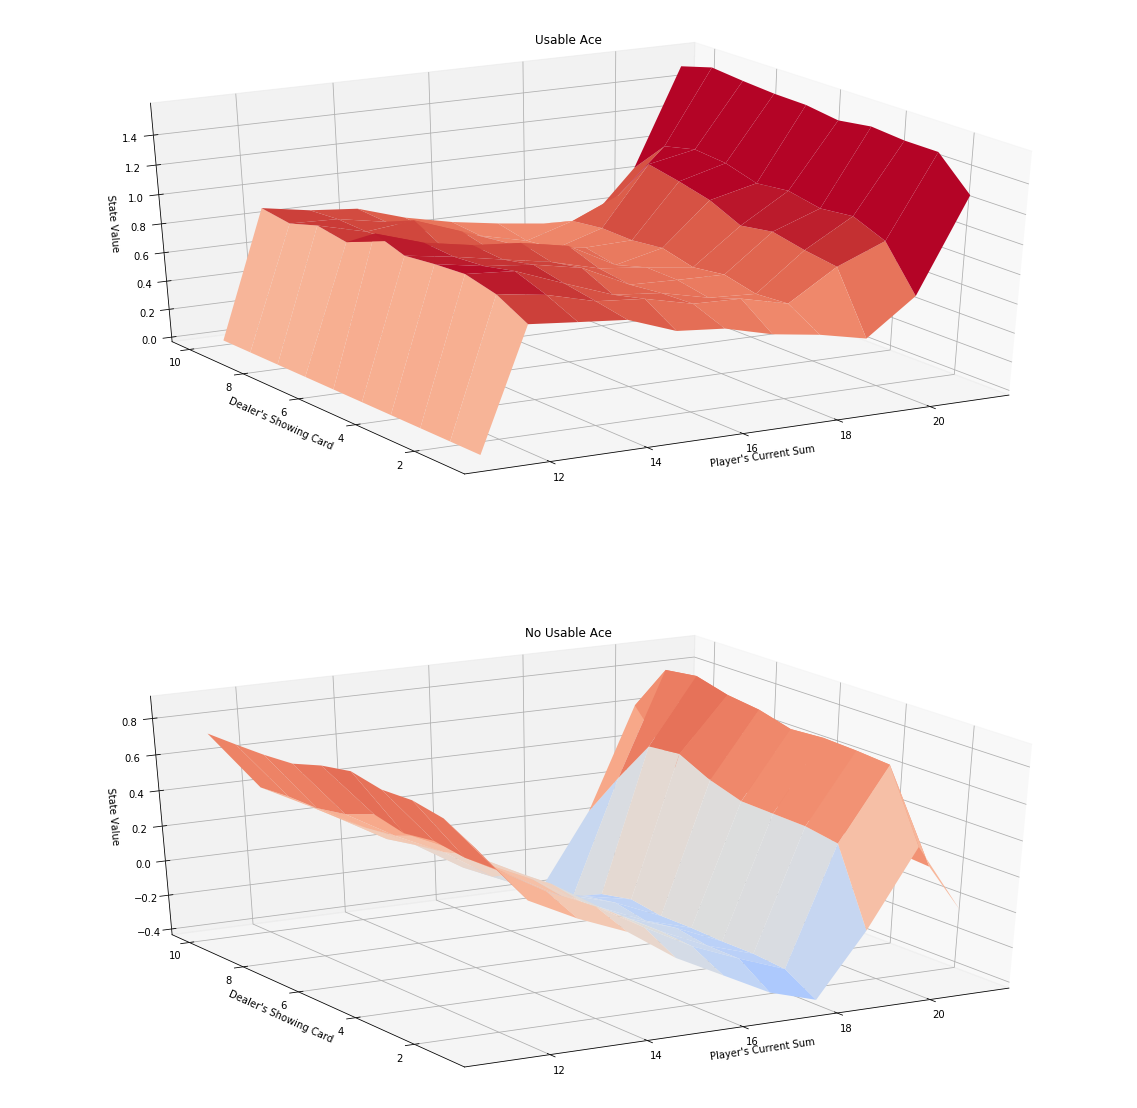

In [14]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 3: MC Control: GLIE

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [15]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        e=1/i_episode
        Q[i_episode]=e-np.argmax(Q)
        
        episode=generate_episode(env)  
 
        states=np.array(episode)[:,0]
        actions=np.array(episode)[:,1] # not noting down what action was taken, only their average sum
        rewards=np.array(episode)[:,2]
        
        #print (rewards)
        
#         statess, actionss, rewardss = zip(*episode)
#         discounts = np.array([gamma**i for i in range(len(rewardss)+1)])
        
        for rownumber,draws in enumerate(episode):
            FutureRewards.append(gamma*sum(np.array(episode)[rownumber+1:len(episode),-1])) # future rewards for that combination
        #print (FutureRewards)    
        # be cautious while using : for slicing data.. better to len()
        for i,state in enumerate(states):
    #         print (state)
            returns_sum[state][actions[i]] =returns_sum[state][actions[i]]+ rewards[i]+(FutureRewards[i])
    #         returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] = N[state][actions[i]]+1.0 
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]

    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [16]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

NameError: name 'policy' is not defined

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

### Part 4: MC Control: Constant-$\alpha$

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)